# Cleaning and Filtering step

In [1]:
import pandas as pd
from transformers import AutoTokenizer
import re

## 0. Load the original data

In [2]:
df = pd.read_parquet("./data/original-latam-xix.parquet")
current_len, original_len = len(df), len(df)
df

,newspaper_id,text_id,title,year,city,text
0,PD1006,3000000084-0001-page_0-0,Las bufonadas,1884,"Arequipa, Perú","cualquier cosa, pues solo se hizo circular en ..."
1,PD1006,3000000084-0001-page_0-1,Las bufonadas,1884,"Arequipa, Perú",Preámbulo. El lector tendrá noticia de que por...
2,PD1006,3000000084-0001-page_1-0,Las bufonadas,1884,"Arequipa, Perú",se meten á escribir: y no veo yo lejano el dia...
3,PD1006,3000000084-0001-page_1-1,Las bufonadas,1884,"Arequipa, Perú","LAS BUFONADAS Oh! Califa, lloraron sus años de..."
4,PD1006,3000000084-0001-page_2-0,Las bufonadas,1884,"Arequipa, Perú","DAD DURUNADAD. centavos al mes, y el cargador ..."
...,...,...,...,...,...,...
67752,PF746,9-page_0-0,El duende Panama,1898-1903,Panamá,"ALTO, QUIEN VIVE s necesario que les istinenit..."
67753,PF746,9-page_0-1,El duende Panama,1898-1903,Panamá,"8ª EPOCA. REPUBLICA DE COLOMBIA, Semanario Cri..."
67754,PF746,9-page_0-2,El duende Panama,1898-1903,Panamá,"lación del ejercicio de la Prensa, se refiere...."
67755,PF746,9-page_0-3,El duende Panama,1898-1903,Panamá,nes ou las poblaciones sudamericanes. - y man ...


## 1. Remove duplicates and empty texts

In [3]:
to_remove = df[df.duplicated(subset=["text", "title"], keep=False)]
df = df.drop_duplicates(subset=["text", "title"], keep="first")
df = df.reset_index(drop=True)
print(f"Removed {current_len - len(df)} rows [{(current_len - len(df))/original_len:.2%}]")
current_len = len(df)
to_remove.tail(5)

Removed 2064 rows [3.05%]


,newspaper_id,text_id,title,year,city,text
67491,PF730,20230917_113327-page_0-1,Mefistofeles,1897-1905,Bogotá,Adelante ! MEFISTOFELES día es mayor el entusi...
67492,PF730,20230917_113534 (1)-page_0-0,Mefistofeles,1897-1905,Bogotá,"erplejos ante acontecimiento pañolas, conocimo..."
67493,PF730,20230917_113534 (1)-page_0-1,Mefistofeles,1897-1905,Bogotá,"ogrotá, martes 21 de Febrero de 1905 RENTREDO ..."
67494,PF730,20230917_113534-page_0-0,Mefistofeles,1897-1905,Bogotá,"ogrotá, martes 21 de Febrero de 1905 RENTREDO ..."
67495,PF730,20230917_113534-page_0-1,Mefistofeles,1897-1905,Bogotá,"erplejos ante acontecimiento pañolas, conocimo..."


In [4]:
to_remove = df[df['text'].astype(str).str.len() == 0]
df = df[df['text'].astype(str).str.len() > 0]
df = df.reset_index(drop=True)
print(f"Removed {current_len - len(df)} rows [{(current_len - len(df))/original_len:.2%}]")
current_len = len(df)
to_remove.tail(5)

Removed 21 rows [0.03%]


,newspaper_id,text_id,title,year,city,text
45626,PD1776,ElMosquito187012-page_3-2,El mosquito,1863-1887,"Buenos Aires, Argentina",
49452,PD1809,1 El Correo del Domingo_ Agosto 1864 - julio 1...,El correo del domingo,1864,"Buenos Aires, Argentina",
52290,PD1985,BNA_S001184221_18960405N034c-page_0-3,Don Quijote,1884-1903,"Buenos Aires, Argentina",
58104,PD662,ps19_elfisgon_1873_pte1-page_0-2,El fisgon,1873-1874,Bogotá,
63615,PD814,nc01ark__13960_t2p56qp06-seq_30-page_0-1,El venezolano,1883-1884,"Caracas, Venezuela",


## 2. Remove rows where 50%+ of the characters are not letters

In [5]:
def useful_chars(string):
    return re.sub(r'[^a-zA-ZÀ-ÿ]', '', string)

In [6]:
idx_min = []
for i, sentence in enumerate(df['text'].astype(str)):
    sentence = re.sub(r'\s+', ' ', sentence.strip())
    size = len(sentence)
    letters_pctg = (size-len(useful_chars(sentence)))/size
    if letters_pctg > 0.5:
        idx_min.append(i)

print("\n".join([df.loc[i, "text"] for i in idx_min]))

20 p 335 x 215 mm. Nº 110: 28 La 10 p. 280 x "Sálvese " S.A. 84 p. 168 x
comentario, Lima, Imp. Ed. 145 p. 213 x 166 Nº 30: Lima, Lima, Ed.
Nº 307-D. 11 mayo P 304-D: 11 mayo 31 mayo LiPartitu
Nº 199-D: 20 1 p. 296 x 210 Lima, Par"Seguros de vida Li A 2.
Nº Lima, 1971 1 p. , 1971. Lima. 1 p. 296 Disco Nº 279-D: 296 x 210 mm. 2 p. 238 x 168 mm. Lima. 1 p. Nº ENRIQUE. Lima, De.
Nº . 202 x 161 mm. Nº 219-D: 22
No 228-D: 28 abril . Disco 45 Nº 245-D: 2
Nº 264-D: 30 abril
1 p. 296 x 210 mm. 1 p. 280 x 215 mm. Historigrama; Nº 14-D: 27 enero El Viejo molino; 2 p. 253 x 178 LiLima. 2 p. Partitura musical
1 p. 296 x 210 mm. Disco 45 R.p.m. Lima. 75 p. 310 Los Románti117 p. 295 x 228
Anto2 p. 296 x 210 mm. Nº 448-D: 30 2 p. 238 x 168 Sistema 6 p. 280 x Lima FTA. CLEMENTE. Lima. Nº
Lima. 1 SaLima. 1 p. LiJue. La Li10 p. 330 x 214 Lima. 1 p.
Lima. 2 p. 280 2 p. 248 x 172 Dón. Lima. Lima, Nº 50556. Ingrato querer; 1 p. 296 Lima.
1 p. 255 Li Nuevo Perú; re1 p. 296
5
7
.
. .
urru , Tu, ru, ru, mu, r

In [7]:
df.drop(idx_min, inplace=True)
df = df.reset_index(drop=True)
print(f"Removed {current_len - len(df)} rows [{(current_len - len(df))/original_len:.2%}]")
current_len = len(df)

Removed 1180 rows [1.74%]


## 3. Remove the rows that have too few tokens

The paremeter chosen was `6` tokens, including the [CLS] and [SEP] tokens, so the rows to remove really have less than `4` tokens

### 3.1. Train a new tokenizer, based on the original dataset

This is particularly useful for then removing the rows with very few tokens, which are likely to be noise.

In [8]:
VOCAB_SIZE = 52000
TRAINING_BATCH_SIZE = 1000
HF_CHECKPOINT = "dccuchile/bert-base-spanish-wwm-cased"

pretrained_tokenizer = AutoTokenizer.from_pretrained(HF_CHECKPOINT)

training_corpus = (
    df.loc[i:i+TRAINING_BATCH_SIZE, "text"].astype(str) 
    for i in range(0, len(df), TRAINING_BATCH_SIZE)
)

tokenizer = pretrained_tokenizer.train_new_from_iterator(training_corpus, VOCAB_SIZE)

c:\Python312\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [9]:
example = df.loc[5, "text"]
print("BEFORE:", pretrained_tokenizer.tokenize(example)[:20])
print("AFTER:", tokenizer.tokenize(example)[:20])
#tokenizer.save_pretrained("./data/tokenizer")

Token indices sequence length is longer than the specified maximum sequence length for this model (834 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (783 > 512). Running this sequence through the model will result in indexing errors


BEFORE: ['46', '##1', ',', '60', 'Y', '[UNK]', 'de', 'arrepent', '##irse', 'de', 'tal', 'ase', '##r', '##cion', ',', 'I', 'se', 'les', 'bar', '##re']
AFTER: ['46', '##1', ',', '60', 'Y', 'debi', '##ć', 'de', 'arrepentirse', 'de', 'tal', 'aser', '##cion', ',', 'I', 'se', 'les', 'barre', 'una', 'pertene']


### 3.2. Actually find and remove the rows

In [10]:
MIN_TOKENS_LENGTH = 6 # 4 tokens: <[CLS] token1 token2 token3 token4 [SEP]>

idx_min = []
for i, sentence in enumerate(df['text'].astype(str)):
    num_tokens = len(tokenizer(sentence)['input_ids'])
    if num_tokens < MIN_TOKENS_LENGTH:
        print(f"Removed '{sentence}' [{i}, {num_tokens} tokens]")
        idx_min.append(i)

Removed 'ESCRITA' [125, 4 tokens]
Removed 'IMPRESOR.' [126, 5 tokens]
Removed 'For' [167, 3 tokens]
Removed 'inmediciones' [193, 4 tokens]
Removed 'Torres' [245, 3 tokens]
Removed 'Si de' [251, 4 tokens]
Removed 'el' [555, 3 tokens]
Removed 'Sab' [594, 3 tokens]
Removed 'T.' [601, 4 tokens]
Removed 'Veía à' [606, 5 tokens]
Removed 'Los' [639, 3 tokens]
Removed 'Casarine' [659, 4 tokens]
Removed 'Unreal.' [671, 5 tokens]
Removed '141 Como' [703, 4 tokens]
Removed 'nia' [713, 3 tokens]
Removed 'Ainen à' [729, 5 tokens]
Removed 'que nada og' [734, 5 tokens]
Removed 'Un real' [742, 4 tokens]
Removed '195 conocia' [748, 4 tokens]
Removed 'que' [751, 3 tokens]
Removed 'se ni' [778, 4 tokens]
Removed 'Un real.' [791, 5 tokens]
Removed 'con' [820, 3 tokens]
Removed 'A.' [842, 4 tokens]
Removed 'oso R.' [975, 5 tokens]
Removed 'Los cuadrupe' [982, 5 tokens]
Removed 'de' [1003, 3 tokens]
Removed 'FAMILIAS LAS' [1417, 4 tokens]
Removed 'Se alquila' [3149, 4 tokens]
Removed 'NEW YORK' [3404, 4 tok

In [11]:
df.drop(idx_min, inplace=True)
df = df.reset_index(drop=True)
print(f"Removed {current_len - len(df)} rows [{(current_len - len(df))/original_len:.2%}]")
current_len = len(df)

Removed 415 rows [0.61%]


In [12]:
print(f"Final rows: {len(df)}")
df

Final rows: 64077


,newspaper_id,text_id,title,year,city,text
0,PD1006,3000000084-0001-page_0-0,Las bufonadas,1884,"Arequipa, Perú","cualquier cosa, pues solo se hizo circular en ..."
1,PD1006,3000000084-0001-page_0-1,Las bufonadas,1884,"Arequipa, Perú",Preámbulo. El lector tendrá noticia de que por...
2,PD1006,3000000084-0001-page_1-0,Las bufonadas,1884,"Arequipa, Perú",se meten á escribir: y no veo yo lejano el dia...
3,PD1006,3000000084-0001-page_1-1,Las bufonadas,1884,"Arequipa, Perú","LAS BUFONADAS Oh! Califa, lloraron sus años de..."
4,PD1006,3000000084-0001-page_2-0,Las bufonadas,1884,"Arequipa, Perú","DAD DURUNADAD. centavos al mes, y el cargador ..."
...,...,...,...,...,...,...
64072,PF746,9-page_0-0,El duende Panama,1898-1903,Panamá,"ALTO, QUIEN VIVE s necesario que les istinenit..."
64073,PF746,9-page_0-1,El duende Panama,1898-1903,Panamá,"8ª EPOCA. REPUBLICA DE COLOMBIA, Semanario Cri..."
64074,PF746,9-page_0-2,El duende Panama,1898-1903,Panamá,"lación del ejercicio de la Prensa, se refiere...."
64075,PF746,9-page_0-3,El duende Panama,1898-1903,Panamá,nes ou las poblaciones sudamericanes. - y man ...


In [13]:
df.to_csv("./data/cleaned-latam-xix.tsv", sep="\t", index=False)
df.to_parquet('./data/cleaned-latam-xix.parquet')

## Post-analysis

In [14]:
originaldf = pd.read_parquet("./data/original-latam-xix.parquet")
# select all rows that are on originaldf but not in df
removed_df = originaldf.merge(df, how='left', indicator=True).loc[lambda x: x['_merge'] == 'left_only']

removed_df['year'] = removed_df['year'].str.split('-').str[0]
removed_df['year'] = removed_df['year'].astype(int)

removed_df

,newspaper_id,text_id,title,year,city,text,_merge
38,PD1029,publication (1)-page_105-2,El nuevo depositario,1821,"Lima, Perú","20 p 335 x 215 mm. Nº 110: 28 La 10 p. 280 x ""...",left_only
45,PD1029,publication (1)-page_107-3,El nuevo depositario,1821,"Lima, Perú","comentario, Lima, Imp. Ed. 145 p. 213 x 166 Nº...",left_only
49,PD1029,publication (1)-page_108-3,El nuevo depositario,1821,"Lima, Perú",Nº 307-D. 11 mayo P 304-D: 11 mayo 31 mayo LiP...,left_only
60,PD1029,publication (1)-page_111-2,El nuevo depositario,1821,"Lima, Perú","Nº 199-D: 20 1 p. 296 x 210 Lima, Par""Seguros ...",left_only
68,PD1029,publication (1)-page_113-2,El nuevo depositario,1821,"Lima, Perú","Nº Lima, 1971 1 p. , 1971. Lima. 1 p. 296 Disc...",left_only
...,...,...,...,...,...,...,...
67487,PF730,20230917_113321-page_0-1,Mefistofeles,1897,Bogotá,Si mi dolor sin límites supieras !... ¡ Si me ...,left_only
67490,PF730,20230917_113327-page_0-0,Mefistofeles,1897,Bogotá,"architas su perfume, y la hoja seca sidenciale...",left_only
67491,PF730,20230917_113327-page_0-1,Mefistofeles,1897,Bogotá,Adelante ! MEFISTOFELES día es mayor el entusi...,left_only
67494,PF730,20230917_113534-page_0-0,Mefistofeles,1897,Bogotá,"ogrotá, martes 21 de Febrero de 1905 RENTREDO ...",left_only


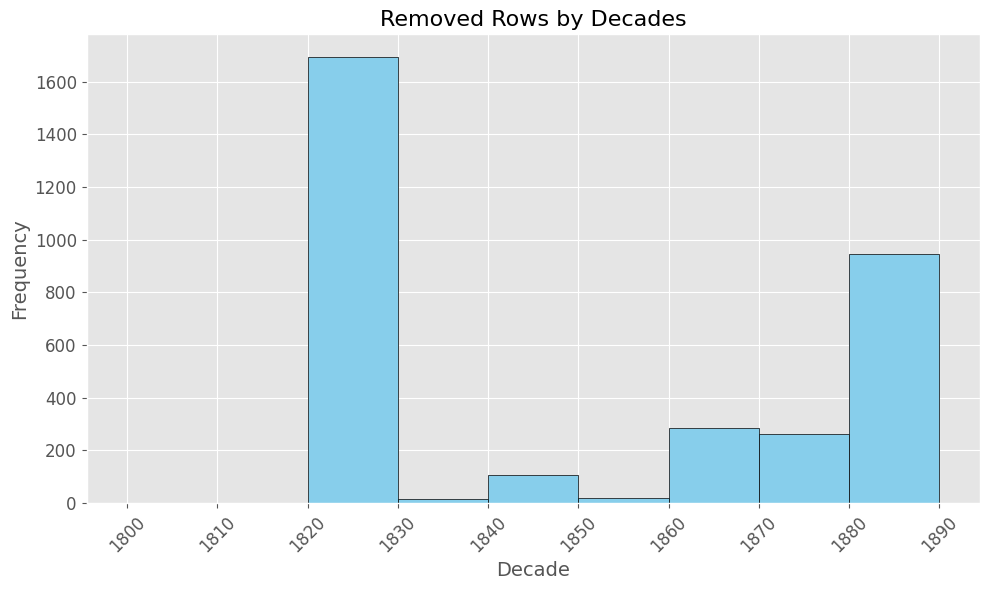

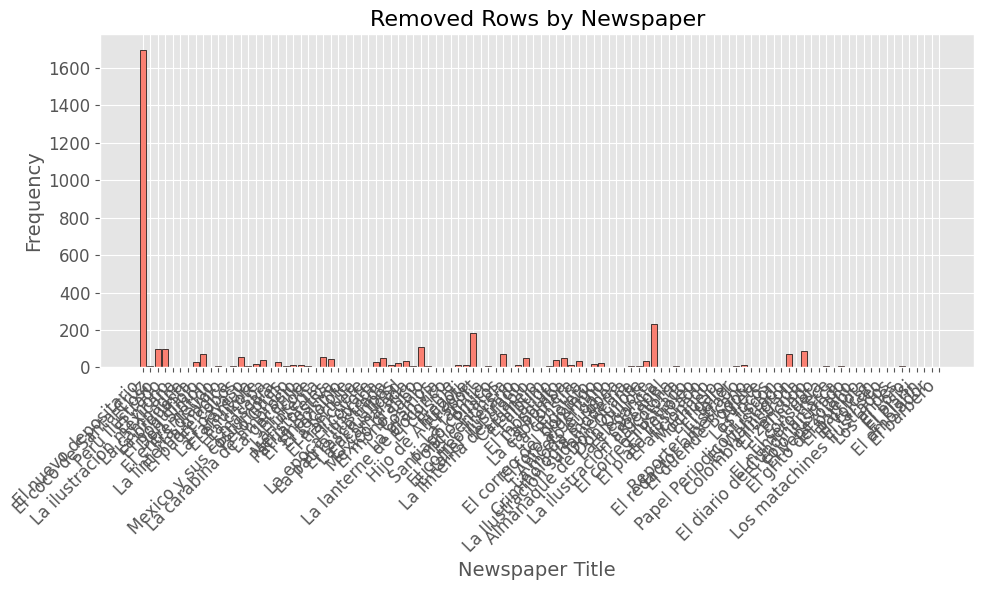

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Set style
plt.style.use('ggplot')

min_year = removed_df['year'].min()
max_year = removed_df['year'].max()
decades_range = np.arange((min_year // 10) * 10, ((max_year // 10) + 1) * 10, 10)

plt.figure(figsize=(10, 6))
plt.hist(removed_df['year'], bins=decades_range, color='skyblue', edgecolor='black')
plt.title('Removed Rows by Decades', fontsize=16)
plt.xlabel('Decade', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(decades_range, rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('./imgs/removed_years_histogram.png', dpi=300)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(removed_df['title'], color='salmon', edgecolor='black', bins=np.arange(len(removed_df['title'].unique())) - 0.5, rwidth=0.8)
plt.title('Removed Rows by Newspaper', fontsize=16)
plt.xlabel('Newspaper Title', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('./imgs/removed_titles_histogram.png', dpi=300)
plt.show()